# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 21.09.2020

Мягкий дедлайн: 02:59MSK 05.10.2020

Жесткий дедлайн: 23:59MSK 08.10.2020

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 10.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [3]:
df = pd.read_csv("train.csv")

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [4]:
df = df.drop("dropoff_datetime", 1)
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

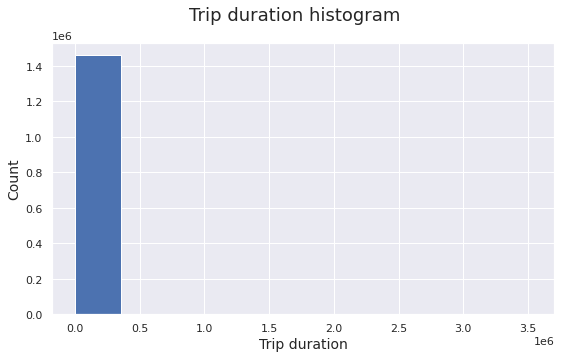

In [5]:
plt.figure(figsize=(9, 5))
plt.hist(df["trip_duration"])
plt.suptitle("Trip duration histogram", fontsize=18)
plt.xlabel("Trip duration", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

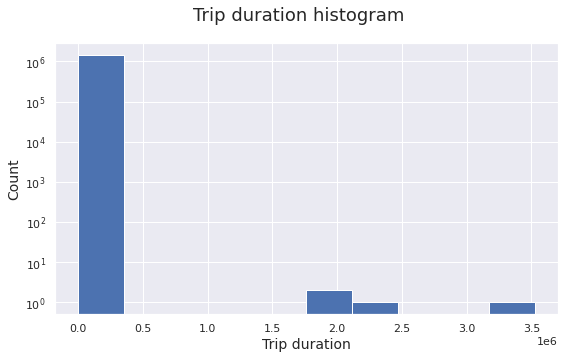

In [6]:
plt.figure(figsize=(9, 5))
plt.hist(df["trip_duration"], log=True)
plt.suptitle("Trip duration histogram", fontsize=18)
plt.xlabel("Trip duration", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

И просто подробнее посмотрим отдельно на относительно небольшие значения:

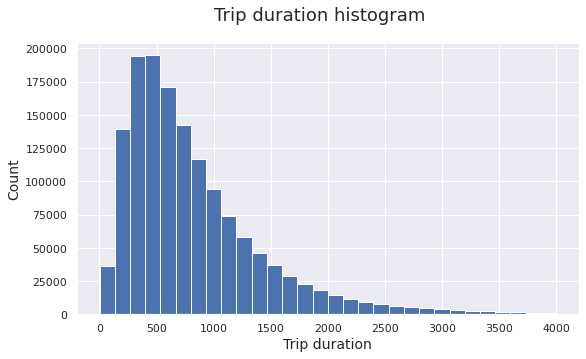

In [7]:
plt.figure(figsize=(9, 5))
plt.hist(df["trip_duration"].loc[df["trip_duration"] < 4000], bins=30)
plt.suptitle("Trip duration histogram", fontsize=18)
plt.xlabel("Trip duration", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Видно, что есть выбросы. По третьей гистограмме видно, что достаточно часть длительность поездок составляет около 500-1000 секунд, центр распределения смещён влево. То есть, люди реже заказывают такси для длительных поездок (более 1000 секунд) или, например, попадают в долгие пробки. Чаще поедзки длятся до 500 секунд.

В соревновании в качестве метрики качества использовалось RMSLE:

$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: RMSLE они выбрали, чтобы сильнее штрафовать за недопрогноз длительности поездки. Это значит, что недопрогноз по каким-то причинам менее выгоден компании. Возможно, потому что из-за этого могут быть ошибочные предположения насчёт количества свободных такси, количества потраченного топлива, получится завышенная прибыль. Может быть, это будет не оправдывать ожидание клиентов насчёт длительности поездки, если они видят эту информацию.

В общем, лучше приятно удивиться, чем разочароваться в завышенных ожиданиях.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: Сделаем переход от старых переменных к новым:

$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} =$$

$$= \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y_i} - \hat{a}(x_i)\big)^2} = \text{RMSE}(X, \hat{y}, \hat{a})$$

Из семинара мы знаем, что оптимизация RMSE эквивалентна оптимизации MSE, так как оптимизируя корень аргумента, мы оптимизируем и само значение аргумента. Поэтому мы можем решать задачу оптимизации MSE для новых переменных.

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [8]:
df["log_trip_duration"] = np.log1p(df["trip_duration"])

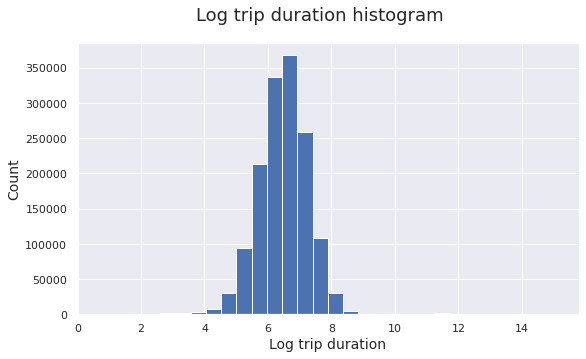

In [9]:
plt.figure(figsize=(9, 5))
fig = plt.hist(df["log_trip_duration"], bins=30)
plt.suptitle("Log trip duration histogram", fontsize=18)
plt.xlabel("Log trip duration", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

In [10]:
df = df.drop("trip_duration", 1)

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [11]:
best_constant = df["log_trip_duration"].mean()
print("Best constant = %.4f seconds" % np.expm1(best_constant))

Best constant = 642.5363 seconds


In [12]:
from sklearn.metrics import mean_squared_error

print(
    mean_squared_error(
        df["log_trip_duration"], best_constant * np.ones(df["log_trip_duration"].shape)
    )
)

0.6332327625405553


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [13]:
df = df.sort_values(by='pickup_datetime')

На графике уберём из подписей каждую вторую дату для горизонтальной оси, чтобы их было лучше видно:

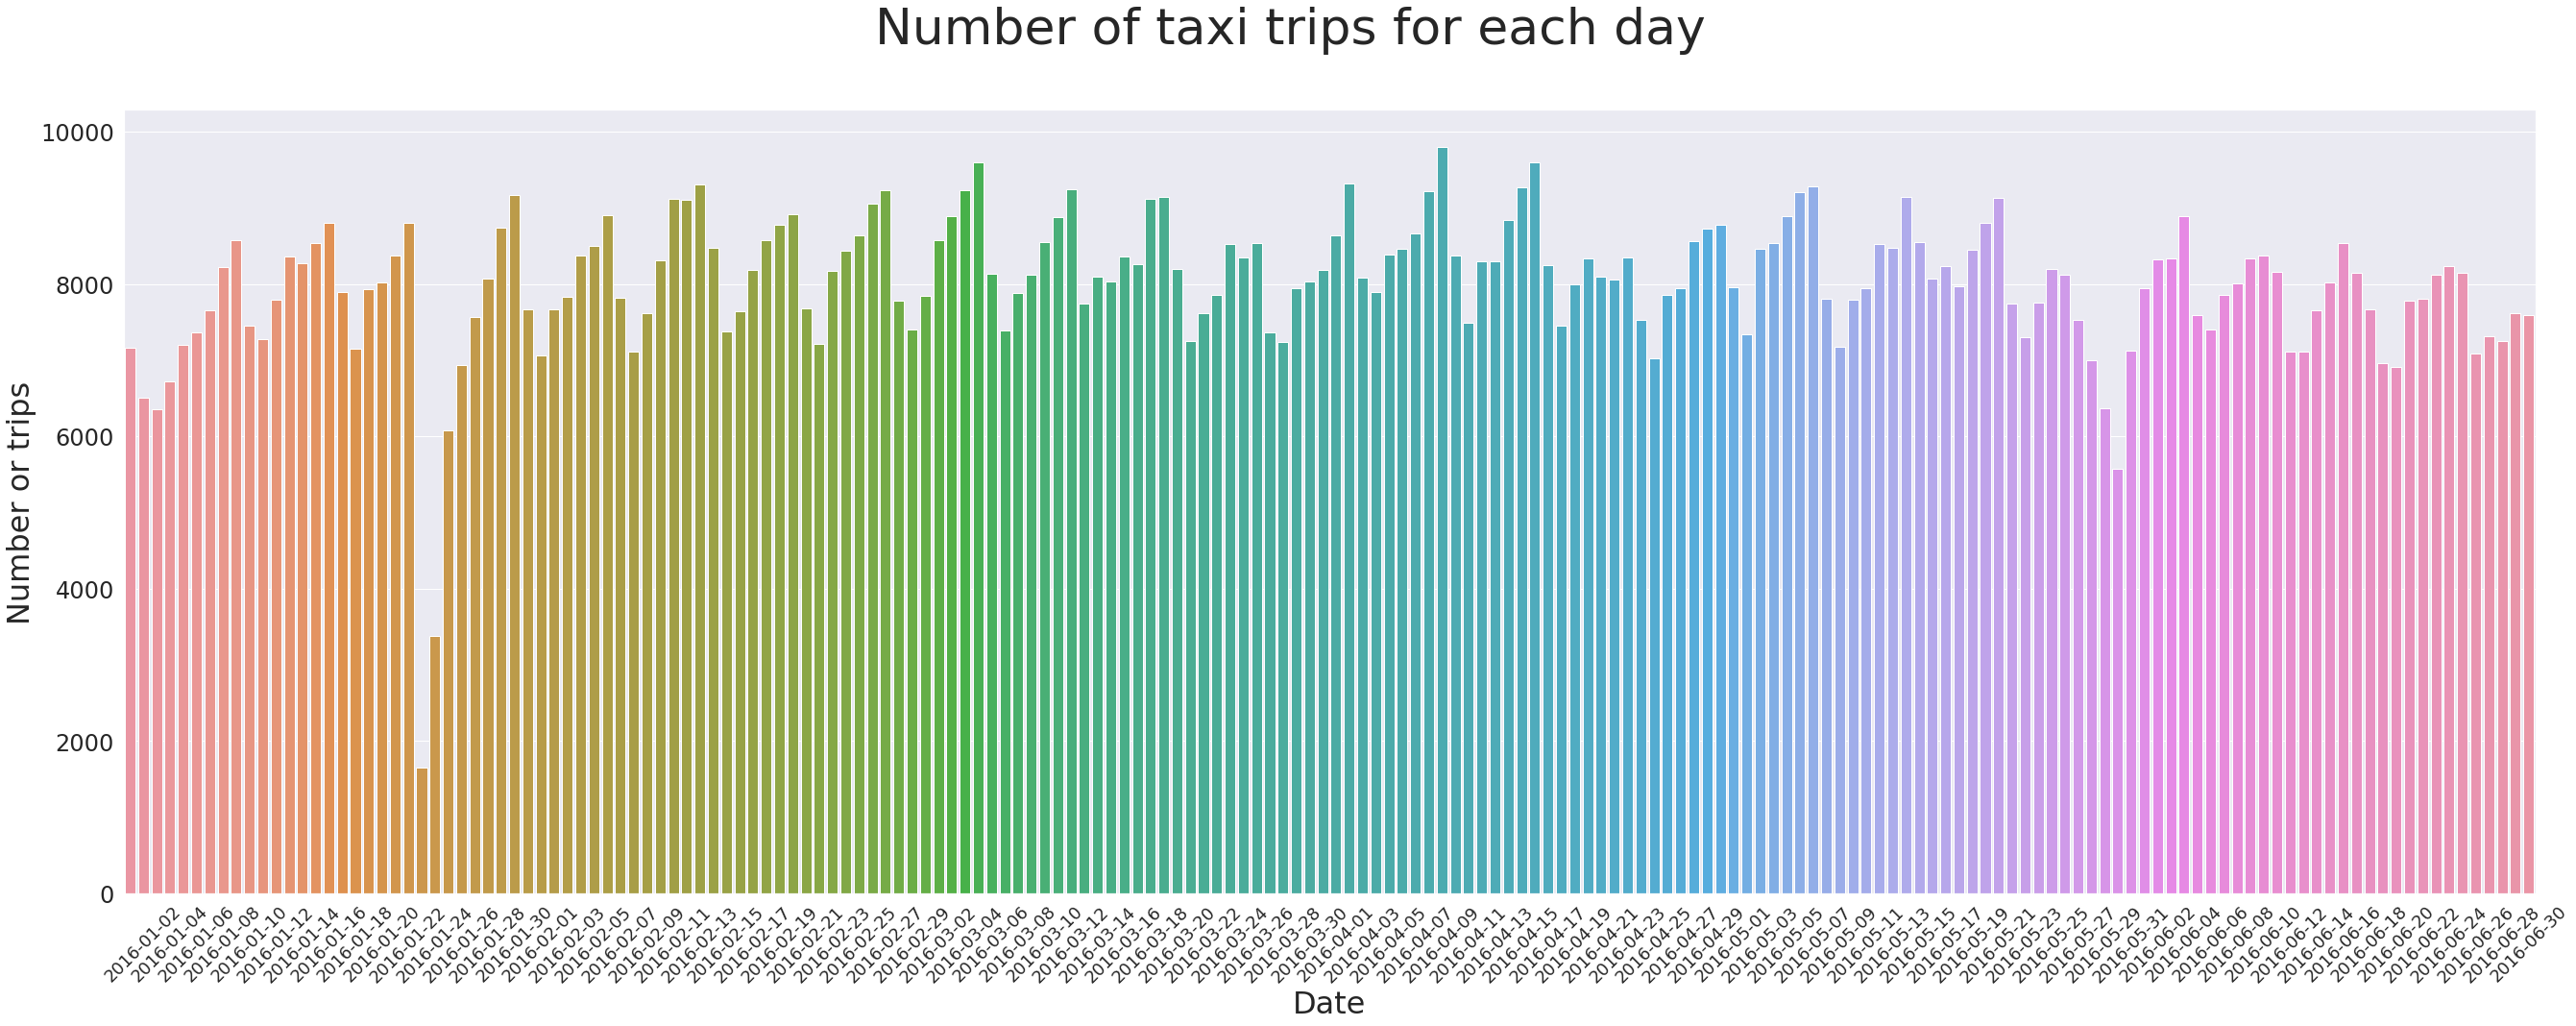

In [14]:
plt.figure(figsize=(45, 15))
fig = sns.countplot(x = df["pickup_datetime"].dt.date)
plt.suptitle("Number of taxi trips for each day", fontsize=52)
plt.xlabel("Date", fontsize=32)
plt.ylabel("Number or trips", fontsize=32)
plt.yticks(fontsize=24)
plt.xticks(rotation=45, fontsize=18)
for label in fig.get_xticklabels()[::2]:
    label.set_visible(False)
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

**Ответ**: В период с 21 января по 29 января 2016 года в Нью-Йорке были сильные снегопады, что создавало проблемы для передвижения людей и транспорта. Ниже я прикреплю видео, которое было снято в Нью-Йорке в тот период.

Период снижения с 27 мая по 31 не такой критический. 30 мая 2016 года в США был праздник - День поминовения. Обычно люди либо проводят время дома, либо едут за город, для таких целей такси обычно не берут, так как дорого. Также в те дни была не самая приятная погода: температура достигала 30 градусов по Цельсию, а 30 мая утром был сильный дождь, что снижает мотивацию лишний раз выходить из дома.

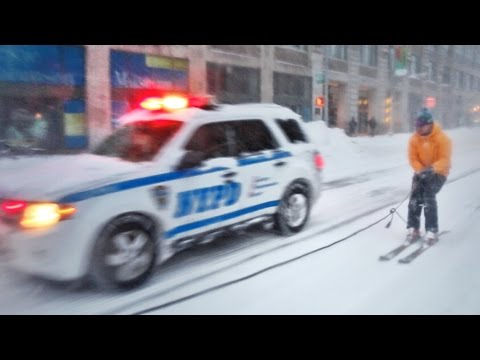

In [15]:
from IPython.display import YouTubeVideo

YouTubeVideo('qRv7G7WpOoU', width=800, height=500)

In [16]:
df["weekday"] = df["pickup_datetime"].dt.weekday

In [17]:
temp = df.groupby([df["pickup_datetime"].dt.date, "weekday"]).count()[["id"]].reset_index()
temp = temp.drop("pickup_datetime", 1)
temp = temp.groupby("weekday")[["id"]].mean().reset_index()

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

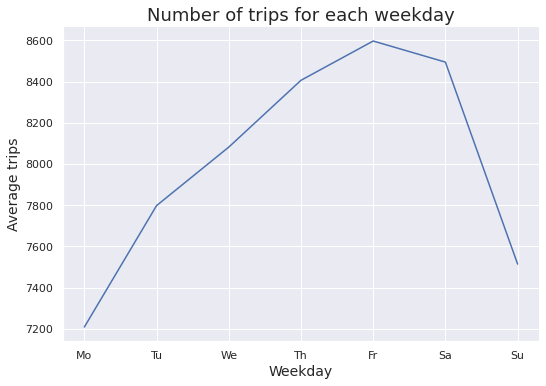

In [18]:
import warnings

warnings.simplefilter("ignore")
fig = sns.relplot(
    data=temp,
    x="weekday",
    y="id",
    kind="line",
    height=5,
    aspect=1.5,
)
plt.title("Number of trips for each weekday", fontsize=18)
fig.set(xticklabels=["", "Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"])
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Average trips", fontsize=14)
plt.show()

In [19]:
df["hour"] = df["pickup_datetime"].dt.hour

In [20]:
temp = df.groupby([df["pickup_datetime"].dt.date, "hour"]).count()[["id"]].reset_index()
temp = temp.drop("pickup_datetime", 1)
temp = temp.groupby("hour")[["id"]].mean().reset_index()

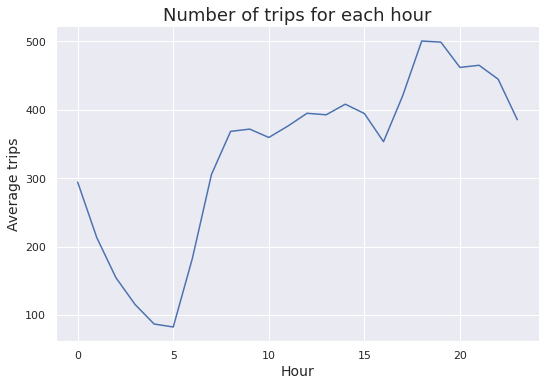

In [21]:
fig = sns.relplot(
    data=temp,
    x="hour",
    y="id",
    kind="line",
    height=5,
    aspect=1.5,
)
plt.title("Number of trips for each hour", fontsize=18)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Average trips", fontsize=14)
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [22]:
df["month"] = df["pickup_datetime"].dt.month

In [23]:
temp = df.groupby([df["pickup_datetime"].dt.date, "month", "hour"]).count()[["id"]].reset_index()
temp = temp.groupby(["month", "hour"]).mean()[["id"]].reset_index()

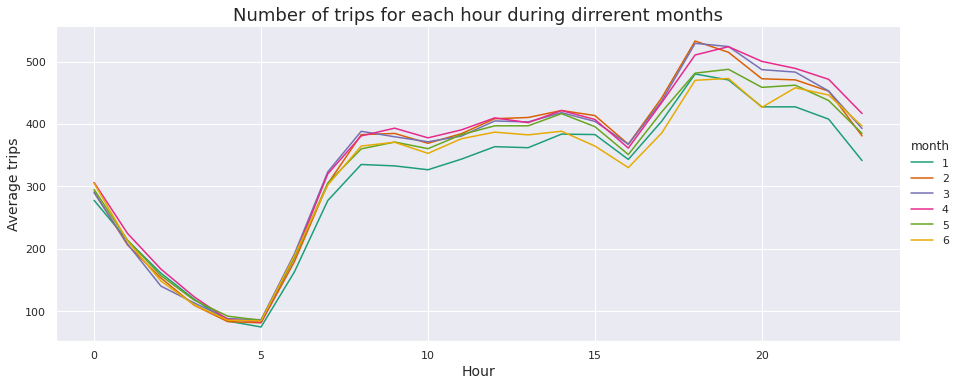

In [24]:
fig = sns.relplot(
    data=temp,
    x="hour",
    y="id",
    hue="month",
    kind="line",
    height=5,
    aspect=2.5,
    markers=True,
    palette ="Dark2"
)
plt.title("Number of trips for each hour during dirrerent months", fontsize=18)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Average trips", fontsize=14)
plt.show()

In [25]:
temp = df.groupby([df["pickup_datetime"].dt.date, "weekday", "hour"]).count()[["id"]].reset_index()
temp = temp.groupby(["weekday", "hour"]).mean()[["id"]].reset_index()

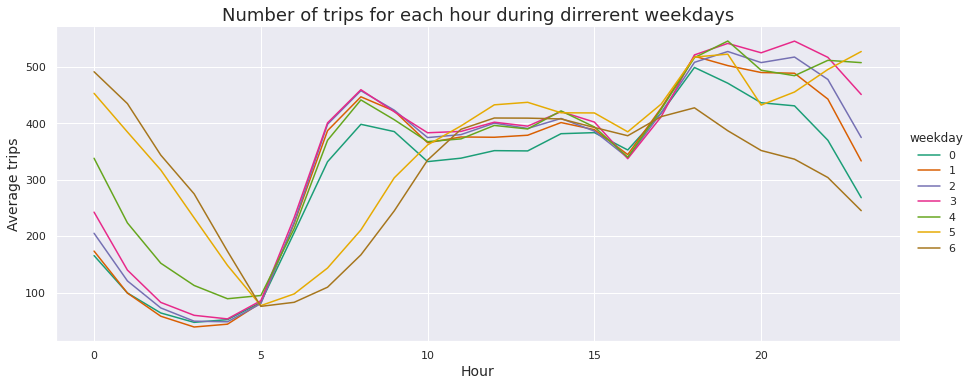

In [26]:
fig = sns.relplot(
    data=temp,
    x="hour",
    y="id",
    hue="weekday",
    kind="line",
    height=5,
    aspect=2.5,
    markers=True,
    palette ="Dark2"
)
plt.title("Number of trips for each hour during dirrerent weekdays", fontsize=18)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Average trips", fontsize=14)
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Видно, что в выходные в целом поездок меньше, однако в субботу ближе к ночи поездок больше, чем в будние дни, видимо, люди едут куда-нибудь в бары, клубы, а в 19:00-21:00 собираются, потому что там уменьшение количества поездок. С 6:00 до 10:00 в будние дни увеличивается количество поездок, так как люди едут на работу. Также в будние дни вечером поездок больше, так как, скорее всего, многие берут такси с работы.

Видно незначительное снижение поездок в мае, скорее всего, погода улучшается, уже не снег и холод, поэтому некоторые люди предпочитают ездить на велосипеде или добираться пешком до работы. В целом, поведение клиентов в течение этих месяцев достаточно однообразное.

**Задание 4 (0.5 баллов)**. По *обучающей выборке* нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

Вы просите разбить выборку в следующем задании, но я разобью сейчас тогда:

In [27]:
from sklearn.model_selection import train_test_split

y = df["log_trip_duration"]
X = df.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

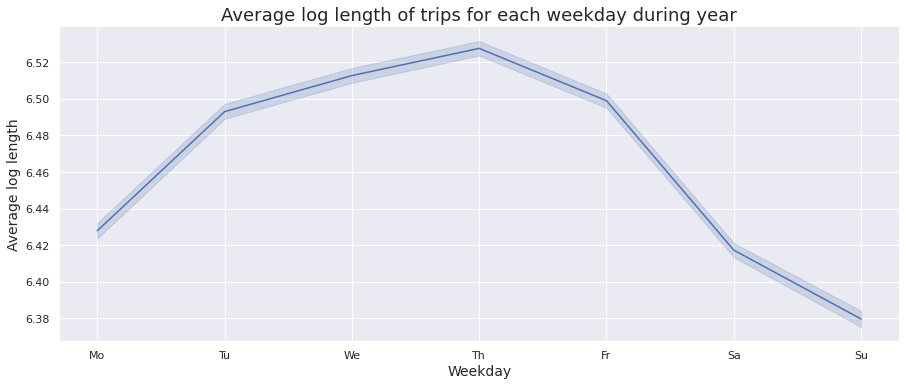

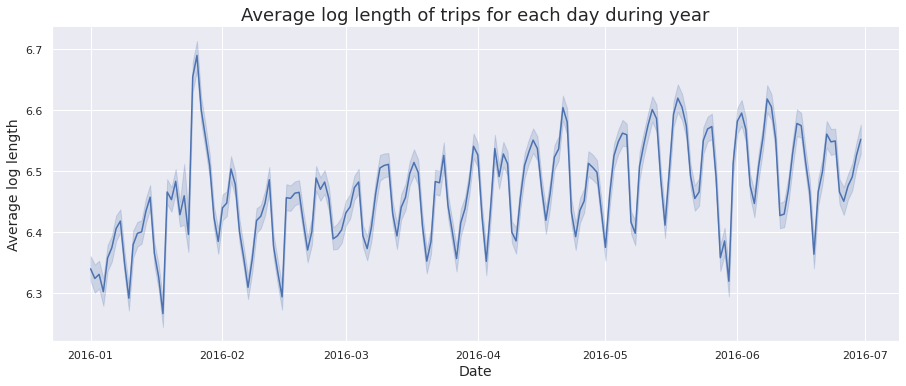

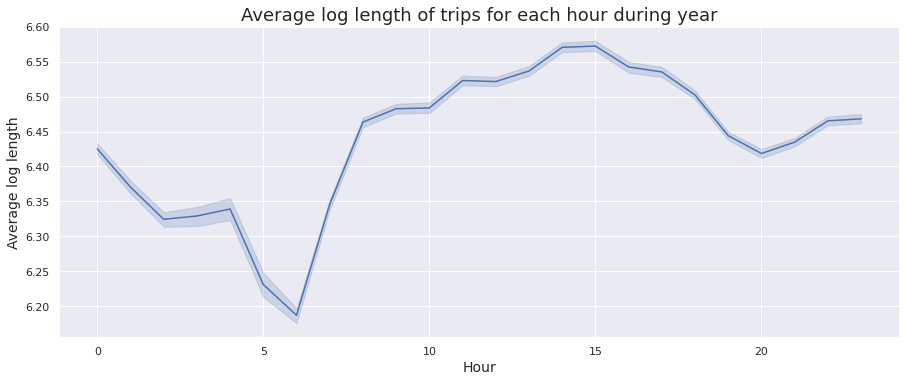

In [28]:
fig = sns.relplot(
    x=X_train["pickup_datetime"].dt.weekday,
    y=y_train,
    kind="line",
    height=5,
    aspect=2.5,
    markers=True,
    palette="Dark2",
)
plt.title("Average log length of trips for each weekday during year", fontsize=18)
fig.set(xticklabels=["", "Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"])
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Average log length", fontsize=14)

plt.show()
fig = sns.relplot(
    x=X_train["pickup_datetime"].dt.date,
    y=y_train,
    kind="line",
    height=5,
    aspect=2.5,
    palette="Dark2",
)
plt.title("Average log length of trips for each day during year", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Average log length", fontsize=14)
plt.show()

fig = sns.relplot(
    x=X_train["pickup_datetime"].dt.hour,
    y=y_train,
    kind="line",
    height=5,
    aspect=2.5,
    palette="Dark2",
)
plt.title("Average log length of trips for each hour during year", fontsize=18)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Average log length", fontsize=14)
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**: Да, log длина поездок достаточно похожа на количество поездок в течение дней недели и часов в сутках. Скорее всего, это происходит, потому что когда много людей берут такси, образуются пробки, из-за которых поездки дольше, к тому же они берут такси обычно в рабочее время, когда и так много людей куда-то едут, а также путь до работы обычно не короткий. Скорее всего, когда такси берут меньшее количество людей (например, выходные), то они едут в более ближние места, а также дороги свободнее.

В период снегопадов видно, что длина поездок сильно увеличилась, потому что движение было крайне медленным. В период дня поминомения длина поездок наоборот была сильно меньше, потому что это праздник, многие люди не работают, значит, дороги уже свободнее, ехать далеко не нужно.

Да, некий тренд есть, он, в принципе, повторяет график зависимости длины поездки от дня недели: к середине недели длина поездок увеличивается, на выходные сильно спадает. И видно, что с течением года длительность увеличивается немного.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [29]:
df["dayofyear"] = df["pickup_datetime"].dt.dayofyear

In [30]:
df.loc[
    (df["pickup_datetime"].dt.date < pd.Timestamp("2016-01-29").date())
    & (df["pickup_datetime"].dt.date > pd.Timestamp("2016-01-21").date()),
    "snowday",
] = 1
df["snowday"] = df["snowday"].replace(np.nan, 0)

In [31]:
df.loc[
    (df["pickup_datetime"].dt.date < pd.Timestamp("2016-05-31").date())
    & (df["pickup_datetime"].dt.date > pd.Timestamp("2016-05-27").date()),
    "memday",
] = 1
df["memday"] = df["memday"].replace(np.nan, 0)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Ответ**: День недели стоит как категориальный, так как их нельзя складывать итд. Так же с часами, vendor_id, store_and_fwd_flag, номером месяца: всё они означают принадлежность объекта к какой-то категории. Остальные признаки можно использовать как числовые. Номер дня в году рассмотрим как числовой, так как он означает увелечение средней длительности поездки (из прошлых графиков), к тому же их достаточно много. Аномальные дни - бинарные признаки, их не меняем через onehot кодирование.

**Задание 5 (0.75 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [32]:
from sklearn.model_selection import train_test_split

y = df["log_trip_duration"]
X = df.drop(columns=["log_trip_duration", "pickup_datetime", "id"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ["hour", "weekday", "month"]
numeric_features = ["dayofyear"]
features = ["weekday", "hour", "month", "dayofyear", "snowday", "memday"]
column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("scaling", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", Ridge())]
)

model = pipeline.fit(X_train[features], y_train)
y_train_pred = model.predict(X_train[features])
y_pred = model.predict(X_test[features])
print("Train RMSE = %.4f" % mean_squared_error(y_train_pred, y_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Train RMSE = 0.7886
Test RMSE = 0.7895


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [34]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [35]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Ответ**: JFK Internation Airport и LaGuardia Airport

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [36]:
#Функция из первого семинара
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [37]:
%%timeit

df["haversine"] = haversine_array(
    df["pickup_latitude"].values,
    df["pickup_longitude"].values,
    df["dropoff_latitude"].values,
    df["dropoff_longitude"].values
)

103 ms ± 306 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [38]:
%%timeit

df["log_haversine"] = np.log1p(df.haversine.values)

29.8 ms ± 523 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

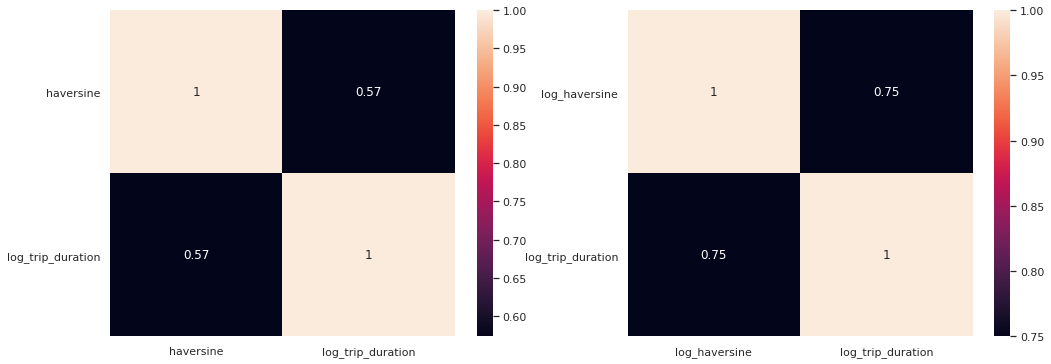

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(17,6))
g = sns.heatmap(df[["haversine", "log_trip_duration"]].corr(), annot=True, ax=ax[0])
g.set_yticklabels(g.get_xticklabels(), rotation=0)
g = sns.heatmap(df[["log_haversine", "log_trip_duration"]].corr(), annot=True, ax=ax[1])
g.set_yticklabels(g.get_xticklabels(), rotation=0)
fig.show()

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [40]:
%%timeit

df["speed"] = df.haversine.values / np.expm1(df.log_trip_duration.values)

36.6 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Переведём скорость в км/ч:

In [41]:
df["speed"] = df["speed"].values * 3600

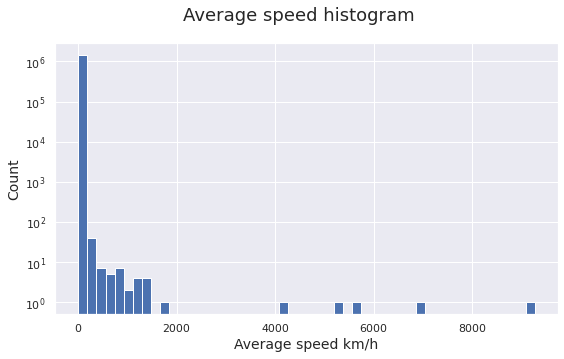

In [42]:
plt.figure(figsize=(9, 5))
plt.hist(df["speed"], bins=50, log=True)
plt.suptitle("Average speed histogram", fontsize=18)
plt.xlabel("Average speed km/h", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

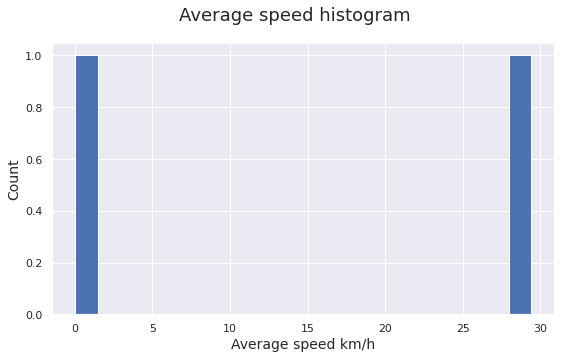

In [43]:
plt.figure(figsize=(9, 5))
plt.hist(df["speed"].quantile([0.0, 0.95]), bins=20)
plt.suptitle("Average speed histogram", fontsize=18)
plt.xlabel("Average speed km/h", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [44]:
speed_dates = df.groupby(["weekday", "hour"])[["speed"]].median().reset_index()
speed_dates = speed_dates.pivot("weekday", "hour", "speed")

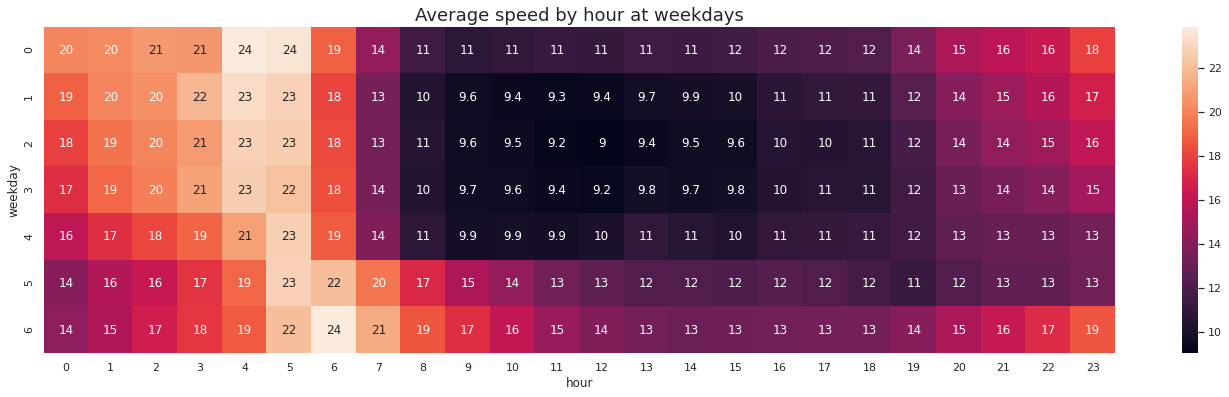

In [45]:
plt.figure(figsize=(24, 6))
ax = plt.axes()
sns.heatmap(speed_dates, annot=True, ax=ax)
ax.set_title("Average speed by hour at weekdays", fontsize=18)
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Потому что мы получили её с помощью времени и расстояния. Время - это ответ, когда мы будем предсказывать с помощью модели ответы для других данных, время будет неизвестным, мы не сможем получить скорость. Также, потому что скорость больше зависит от времени суток и дня недели, например.

In [46]:
df = df.drop("speed", 1)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Когда скорость минимальна - пробки, обычно это рабочие часы. Когда максимальна - дороги свободные, обычно ночью и ранним утром.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [47]:
df.loc[
    (
        ((df["weekday"] == 0) & df["hour"].between(8, 18))
        | ((df["weekday"] == 1) & df["hour"].between(8, 18))
        | ((df["weekday"] == 2) & df["hour"].between(8, 18))
        | ((df["weekday"] == 3) & df["hour"].between(8, 18))
        | ((df["weekday"] == 4) & df["hour"].between(8, 19))
        | ((df["weekday"] == 5) & (df["hour"].between(13, 20)))
        | ((df["weekday"] == 6) & (df["hour"].between(13, 18)))
    ),
    "jams",
] = 1
df["jams"] = df["jams"].replace(np.nan, 0)

In [48]:
df.loc[
    (
        ((df["weekday"] == 0) & (df["hour"].between(0, 6) | df["hour"].between(0, 6)))
        | ((df["weekday"] == 1) & df["hour"].between(0, 6))
        | ((df["weekday"] == 2) & df["hour"].between(0, 6))
        | ((df["weekday"] == 3) & df["hour"].between(0, 6))
        | ((df["weekday"] == 4) & df["hour"].between(0, 6))
        | ((df["weekday"] == 5) & df["hour"].between(3, 8))
        | (
            (df["weekday"] == 6)
            & (df["hour"].between(2, 9) | df["hour"].between(23, 24))
        )
    ),
    "free",
] = 1
df["free"] = df["free"].replace(np.nan, 0)

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.
Второй аэропорт кратко назовём, чтобы время сэкономить:

In [49]:
df.loc[
    (
        df["pickup_longitude"].between(-73.792504, -73.773914)
        & df["pickup_latitude"].between(40.642494, 40.649356)
    ),
    "from_jfk",
] = 1
df["from_jfk"] = df["from_jfk"].replace(np.nan, 0)

df.loc[
    (
        df["pickup_longitude"].between(-73.877245, -73.869660)
        & df["pickup_latitude"].between(40.770786, 40.774312)
    ),
    "from_la",
] = 1
df["from_la"] = df["from_la"].replace(np.nan, 0)

In [50]:
df.loc[
    (
        df["dropoff_longitude"].between(-73.792504, -73.773914)
        & df["dropoff_latitude"].between(40.642494, 40.649356)
    ),
    "to_jfk",
] = 1
df["to_jfk"] = df["to_jfk"].replace(np.nan, 0)

df.loc[
    (
        df["dropoff_longitude"].between(-73.877245, -73.869660)
        & df["dropoff_latitude"].between(40.770786, 40.774312)
    ),
    "to_la",
] = 1
df["to_la"] = df["to_la"].replace(np.nan, 0)

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

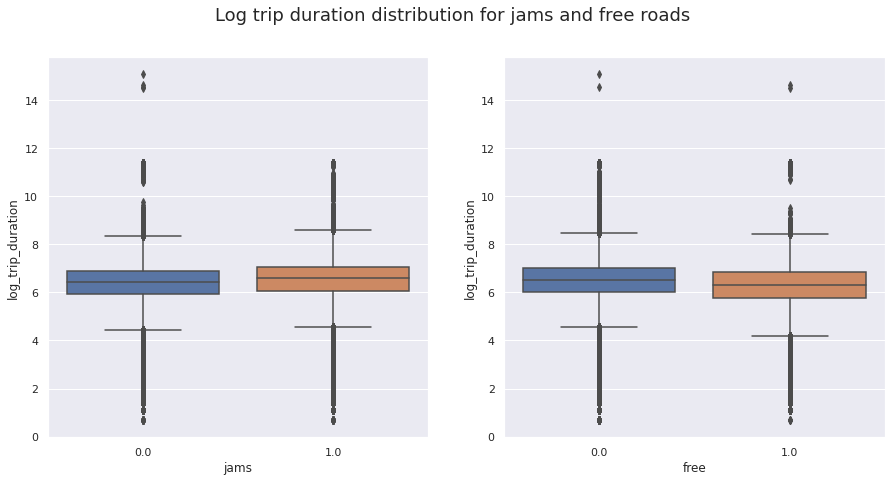

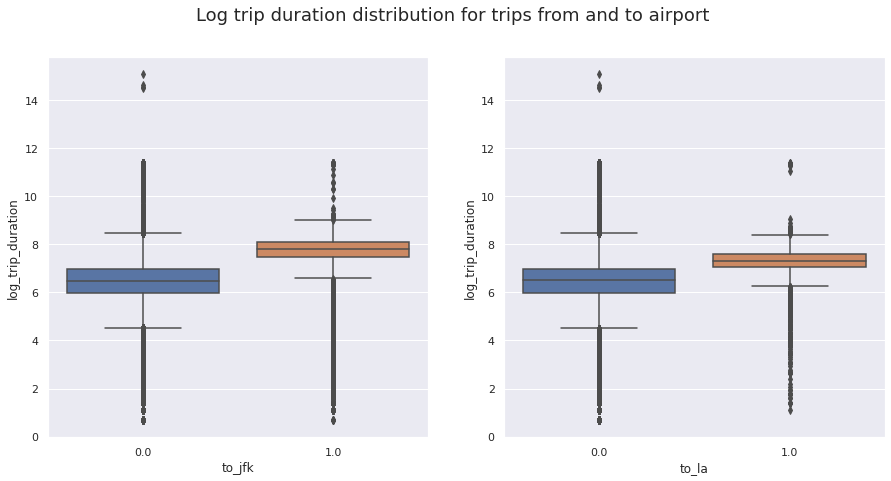

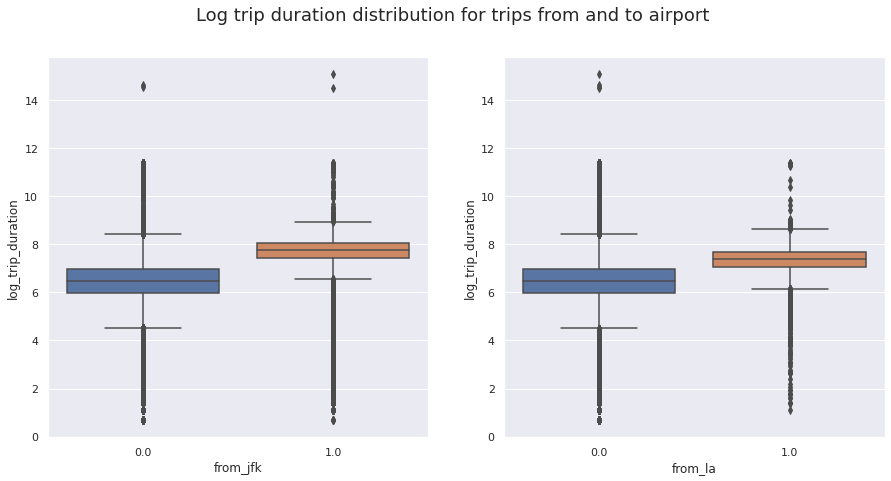

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(x="jams", y="log_trip_duration", data=df, ax=ax[0])
sns.boxplot(x="free", y="log_trip_duration", data=df, ax=ax[1])
fig.suptitle("Log trip duration distribution for jams and free roads", fontsize=18)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(x="to_jfk", y="log_trip_duration", data=df, ax=ax[0])
sns.boxplot(x="to_la", y="log_trip_duration", data=df, ax=ax[1])
fig.suptitle("Log trip duration distribution for trips from and to airport", fontsize=18)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(x="from_jfk", y="log_trip_duration", data=df, ax=ax[0])
sns.boxplot(x="from_la", y="log_trip_duration", data=df, ax=ax[1])
fig.suptitle("Log trip duration distribution for trips from and to airport", fontsize=18)
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ**: Признак поездки из аэропорта или в аэропорта выглядит достаточно хорошим, видно, что такие поездки, в среднем проходят дольше. Признаки с пробками или пустыми дорогами, возможно, не такие хорошие, на графике видна незначительная разница в разбросе значений, но, может быть, с оптимальным весов, это улучшит модель.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.spatial.distance import cdist

titles = dict(
    pick_lon="pickup_longitude",
    pick_lat="pickup_latitude",
    drop_lon="dropoff_longitude",
    drop_lat="dropoff_latitude",
)

# Edge coordinates of the city
city_edges = np.array(
    [
        [40.824376, -74.016890],
        [40.824376, -73.940549],
        [40.710365, -73.940549],
        [40.710365, -74.016890],
    ]
)


class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, location, cols, rows, titles=titles):
        """ Get main params for the function and get coordinates of polygon vertices
        via min-max functions from nparray (location).
        """
        self.location_mh = location
        self.cols = cols
        self.rows = rows
        self.titles = titles
        self.pick_lat = titles["pick_lat"]
        self.pick_lon = titles["pick_lon"]
        self.drop_lat = titles["drop_lat"]
        self.drop_lon = titles["drop_lon"]
        self.lat_min, self.lat_max = location[:, 0].min(), location[:, 0].max()
        self.lon_min, self.lon_max = location[:, 1].min(), location[:, 1].max()

        # Finding distances between borders of cells
        self.borders = [
            (self.lat_max - self.lat_min) / self.cols,
            (self.lon_max - self.lon_min) / self.rows,
        ]

    def create_zones(self):
        """ Method for highlighting zones on the given polygon. We divide borders
        coordinates to put dots exactly between border lines and use loops for iterating
        over all cells.
        """
        self.zone = np.array(
            [
                (
                    (self.lat_min + i * (self.borders[0] / 2)),
                    (self.lon_min + j * (self.borders[1] / 2)),
                )
                for i in range(1, (self.cols) * 2, 2)
                for j in range(1, (self.rows) * 2, 2)
            ]
        )
        return self.zone

    def get_sector(self, Driver):
        """ Method that finds closest zones on the polygon for drivers' pickups and
        dropsoff. Cdist checks distances for all zones and via argmin it returns the
        index of the closest zone (cell). Then it checks if location was in the zone.
        Returns two arrays with integers.
        """
        self.create_zones()
        start = cdist(Driver.loc[:, [self.pick_lat, self.pick_lon]], self.zone).argmin(
            axis=1
        )
        end = cdist(Driver.loc[:, [self.drop_lat, self.drop_lon]], self.zone).argmin(
            axis=1
        )

        start[
            ~(
                Driver["pickup_latitude"].between(self.lat_min, self.lat_max)
                & Driver["pickup_longitude"].between(self.lon_min, self.lon_max)
            )
        ] = -1

        end[
            ~(
                Driver["dropoff_latitude"].between(self.lat_min, self.lat_max)
                & Driver["dropoff_longitude"].between(self.lon_min, self.lon_max)
            )
        ] = -1
        return start, end

In [53]:
new_york = MapGridTransformer(city_edges, 5, 3, titles)

In [54]:
df["start"], df["end"] = new_york.get_sector(df)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [55]:
from sklearn.model_selection import train_test_split

y = df["log_trip_duration"]
X = df.drop(columns=["log_trip_duration", "pickup_datetime", "id"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [56]:
categorical = ["hour", "weekday", "month", "start", "end"]
numeric_features = ["dayofyear", "log_haversine"]
features = [
    "weekday",
    "hour",
    "month",
    "dayofyear",
    "snowday",
    "memday",
    "log_haversine",
    "jams",
    "free",
    "from_jfk",
    "from_la",
    "to_jfk",
    "to_la",
    "start",
    "end"
]
column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("scaling", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", Ridge())]
)

model = pipeline.fit(X_train[features], y_train)
y_train_pred = model.predict(X_train[features])
y_pred = model.predict(X_test[features])
print("Train RMSE = %.4f" % mean_squared_error(y_train_pred, y_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Train RMSE = 0.4849
Test RMSE = 0.4857


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ**: Количество пассажиров может удлинять поездку, если они дольше входят/выходят из машины, а также если кого-то нужно закидывать по пути куда-то. Vendor_id: может быть, какой-то провайдер имеет лучших водителей, может быть, есть какие-то особенные условия, например, один из них работает только с длинными дистанциями или в часы, когда нет пробок - это нужно проверять. 

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [57]:
df.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [58]:
df.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [59]:
df.store_and_fwd_flag.value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

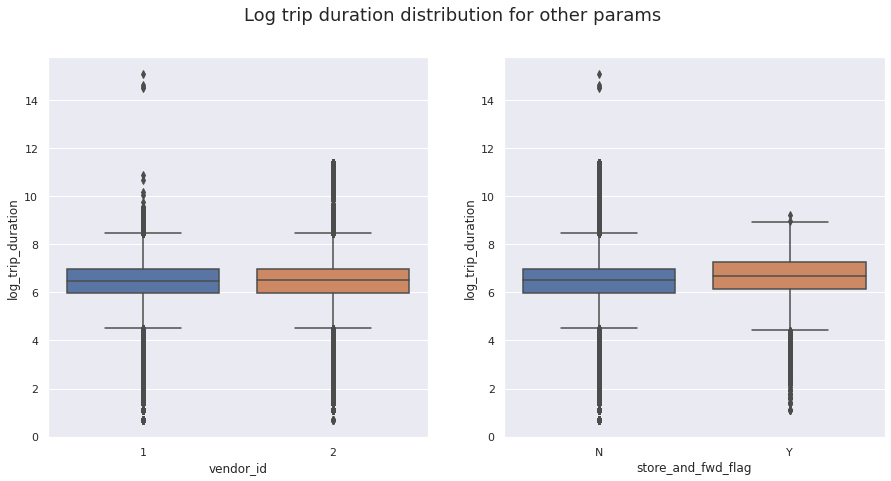

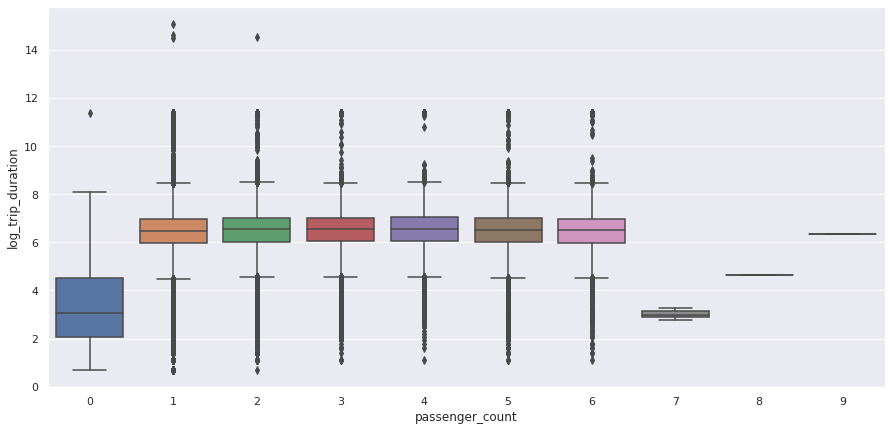

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(x="vendor_id", y="log_trip_duration", data=df, ax=ax[0])
sns.boxplot(x="store_and_fwd_flag", y="log_trip_duration", data=df, ax=ax[1])
fig.suptitle("Log trip duration distribution for other params", fontsize=18)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(15,7))
sns.boxplot(x="passenger_count", y="log_trip_duration", data=df)
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [61]:
df.store_and_fwd_flag = df.store_and_fwd_flag.map(dict(Y=1, N=0))

In [62]:
df["vendor_id"].loc[df.vendor_id == 2] = 0

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ**: Видно, что пассажиры в среднем не сильно влияют на длительность поездки, хотя при некоторых количествах поездки могут идти изредка дольше или быстрее. Vendor_id выглядит так, что мало влияет на результат, хотя у первого больше выбросов. Store_and_fwd_flag когда отсутствует, то длительность поездки немного меньше. В общем, думаю, что признаки, может быть, не сильные, но определённые их комбинации могут дать улучшение модели.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [63]:
from sklearn.model_selection import train_test_split

y = df["log_trip_duration"]
X = df.drop(columns=["log_trip_duration", "pickup_datetime", "id"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [64]:
categorical = ["hour", "weekday", "month", "start", "end"]
numeric_features = ["dayofyear", "log_haversine", "passenger_count"]
features = [
    "weekday",
    "hour",
    "month",
    "dayofyear",
    "snowday",
    "memday",
    "log_haversine",
    "jams",
    "free",
    "from_jfk",
    "from_la",
    "to_jfk",
    "to_la",
    "start",
    "end",
    "vendor_id",
    "store_and_fwd_flag",
    "passenger_count"
]
column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("scaling", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", Ridge())]
)

model = pipeline.fit(X_train[features], y_train)
y_train_pred = model.predict(X_train[features])
y_pred = model.predict(X_test[features])
print("Train RMSE = %.4f" % mean_squared_error(y_train_pred, y_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Train RMSE = 0.4848
Test RMSE = 0.4856


Добавим остатки регрессии:

In [65]:
X_train["res"] = y_train_pred - y_train.values
X_train["log_time"] = y_train

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

У меня, к сожалению, нет сильного улучшения метрики, поэтому придётся их убрать.

In [66]:
X_train = X_train.drop("vendor_id", 1)
X_train = X_train.drop("store_and_fwd_flag", 1)
X_train = X_train.drop("passenger_count", 1)

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

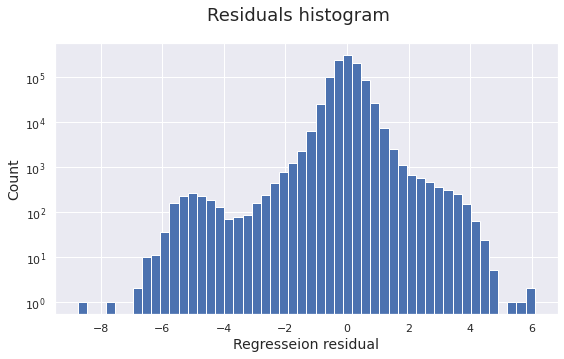

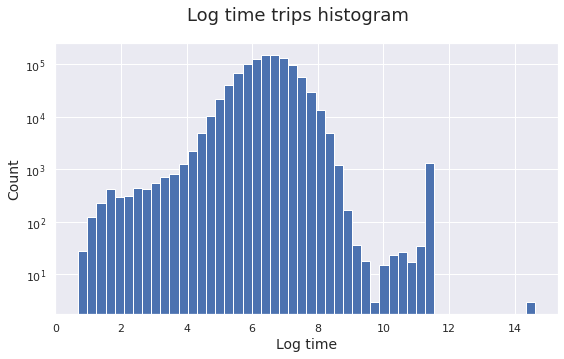

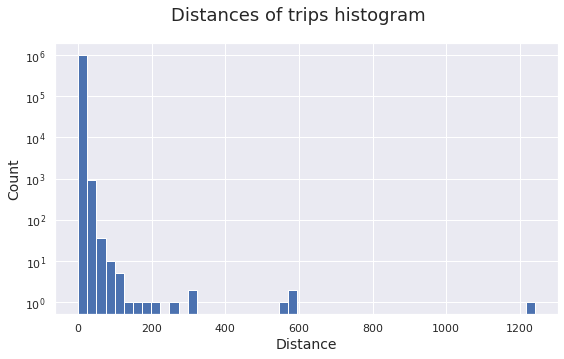

In [67]:
plt.figure(figsize=(9, 5))
plt.hist(X_train["res"], bins=50, log=True)
plt.suptitle("Residuals histogram", fontsize=18)
plt.xlabel("Regresseion residual", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

plt.figure(figsize=(9, 5))
plt.hist(X_train["log_time"], bins=50, log=True)
plt.suptitle("Log time trips histogram", fontsize=18)
plt.xlabel("Log time", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

plt.figure(figsize=(9, 5))
plt.hist(X_train["haversine"], bins=50, log=True)
plt.suptitle("Distances of trips histogram", fontsize=18)
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

Длину поездок ограничим: 4 <= log time <= 8, иначе поездка длится либо минуту, либо несколько часов

Остатки регрессии попробуем взять: -4 <= остаток <= 4

Дистанцию возьмём: 1.5 <= дистанция <= 100

Не будем слишком сильно ограничивать результаты, чтобы модель могла верно обратабывать аномальные данные.

In [68]:
X_train = X_train[X_train["log_time"].between(4, 8)]
X_train = X_train[X_train["haversine"].between(1.5, 100)]
X_train = X_train[X_train["res"].between(-4, 4)]

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

Некоторые категории я уже удалил, а в некоторых слияние сделать нельзя. Поэтому я предлагаю объединить редкие категории, которые означают, что поездка была из определённой ячейки. Ещё можно объединить вместе поездки в аэропорт, так как их было не так много.

In [69]:
X_train.start.value_counts()

 7     125188
 4     116346
 3      78864
-1      74976
 0      67856
 8      63528
 1      37297
 10     36538
 11     30889
 6      14020
 14      6557
 2       3195
 5       2408
 13      1568
Name: start, dtype: int64

Объединим 14, 2, 5, 13 клетки, назовём их просто 14-ой.

In [70]:
X_train["start"].loc[
    (X_train.start == 2) | (X_train.start == 5) | (X_train.start == 13)
] = 14

In [71]:
X_train.to_la.value_counts()

0.0    655391
1.0      3839
Name: to_la, dtype: int64

In [72]:
X_train.from_la.value_counts()

0.0    647016
1.0     12214
Name: from_la, dtype: int64

In [73]:
X_train.from_jfk.value_counts()

0.0    645659
1.0     13571
Name: from_jfk, dtype: int64

In [74]:
X_train.to_jfk.value_counts()

0.0    654806
1.0      4424
Name: to_jfk, dtype: int64

In [75]:
X_train.loc[
    (X_train["from_la"] == 1)
    | (X_train["from_jfk"] == 1)
    | (X_train["to_la"] == 1)
    | (X_train["to_jfk"] == 1),
    "airport",
] = 1
X_train["airport"] = X_train["airport"].replace(np.nan, 0)

In [76]:
X_train = X_train.drop(["from_la", "from_jfk", "to_la", "to_jfk"], 1)

In [77]:
X_train = X_train.drop(["res"], 1)

In [78]:
y_train = X_train["log_time"]

In [79]:
X_test["start"].loc[
    (X_test.start == 2) | (X_test.start == 5) | (X_test.start == 13)
] = 14
X_test.loc[
    (X_test["from_la"] == 1)
    | (X_test["from_jfk"] == 1)
    | (X_test["to_la"] == 1)
    | (X_test["to_jfk"] == 1),
    "airport",
] = 1
X_test["airport"] = X_test["airport"].replace(np.nan, 0)
X_test = X_test.drop(["from_la", "from_jfk", "to_la", "to_jfk"], 1)

In [80]:
X_test = X_test.drop("vendor_id", 1)
X_test = X_test.drop("store_and_fwd_flag", 1)
X_test = X_test.drop("passenger_count", 1)

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [81]:
categorical = ["hour", "weekday", "month", "start", "end"]
numeric_features = ["dayofyear", "log_haversine"]
features = [
    "weekday",
    "hour",
    "month",
    "dayofyear",
    "snowday",
    "memday",
    "log_haversine",
    "jams",
    "free",
    "airport",
    "start",
    "end"
]

column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("scaling", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", Ridge())]
)

model = pipeline.fit(X_train[features], y_train)
y_train_pred = model.predict(X_train[features])
y_pred = model.predict(X_test[features])
print("Train RMSE = %.4f" % mean_squared_error(y_train_pred, y_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Train RMSE = 0.3402
Test RMSE = 0.5112


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [82]:
print("Size before OneHot:", X_train[features].shape)
print("Size after OneHot:", column_transformer.transform(X_train[features]).shape)

Size before OneHot: (659230, 12)
Size after OneHot: (659230, 66)


Их становится действительно больше, особенно потому что у нас было много клеток для поездок.

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

Для разных случаев может быть разный лучше, у нас пока лучше работает Ridge. Lasso умеет занулять линейно-зависимые признаки, что может улучшить показатели.

In [83]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train[features], y_train)
y_train_pred = model.predict(X_train[features])
y_pred = model.predict(X_test[features])
print("Train RMSE = %.4f" % mean_squared_error(y_train_pred, y_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Train RMSE = 0.5327
Test RMSE = 0.8509


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [85]:
from sklearn.model_selection import train_test_split

y_valid = X_train["log_time"]
X = X_train.drop(columns=["log_time"])

X_train, X_valid, y_train, y_valid = train_test_split(X, y_valid, test_size=0.2, random_state=10)

In [86]:
categorical = [
    "hour",
    "weekday",
    "month",
    "start",
    "end",
    "snowday",
    "memday",
    "jams",
    "free",
    "airport",
]
numeric_features = ["dayofyear", "log_haversine"]

column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("scaling", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", Ridge())]
)

lasso_pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", Lasso())]
)

Best alpha = 2.3357


Text(0, 0.5, 'CV score')

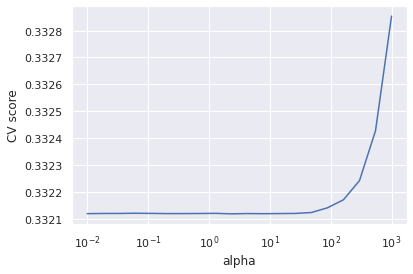

In [87]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
searcher.fit(X_valid, y_valid)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Best alpha = 0.0010


Text(0, 0.5, 'CV score')

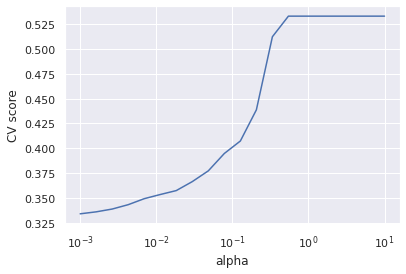

In [88]:
alphas = np.logspace(-3, 1, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
searcher.fit(X_valid, y_valid)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [89]:
lasso_zeros = []
for alpha in alphas:
    pipeline = Pipeline(
        steps=[("ohe_and_scaling", column_transformer), ("regression", Lasso(alpha))]
    )
    pipeline.fit(X_train, y_train)
    lasso_zeros.append(np.sum(pipeline.steps[-1][-1].coef_ == 0))

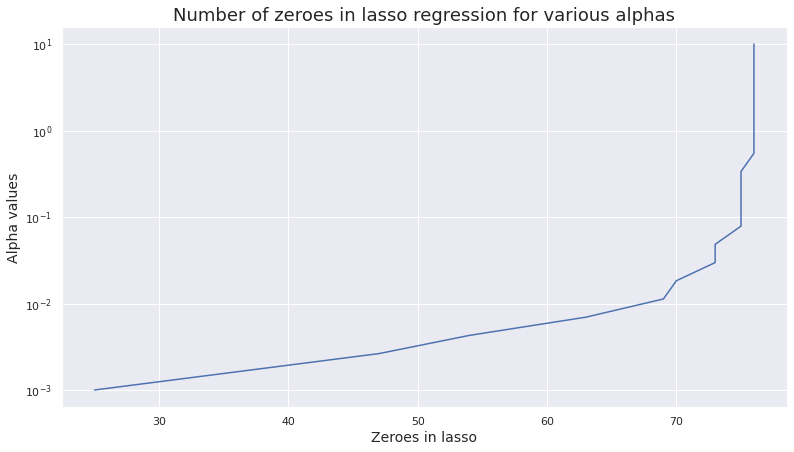

In [90]:
plt.figure(figsize=(13, 7))
fig = plt.plot(lasso_zeros, alphas)
plt.title("Number of zeroes in lasso regression for various alphas", fontsize=18)
plt.ylabel("Alpha values", fontsize=14)
plt.yscale('log')
plt.xlabel("Zeroes in lasso", fontsize=14)
plt.show()

Возьмём лучшую альфу, потом возьмём альфу, при которой убиралась примерно половина признаков, а потом возьмём альфу, при которой убиралось много признаков:

In [91]:
lasso_pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", Lasso(0.0010))]
)

model = lasso_pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train RMSE = %.4f" % mean_squared_error(y_train_pred, y_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Train RMSE = 0.3330
Test RMSE = 0.5051


In [92]:
lasso_pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", Lasso(alphas[1]))]
)

model = lasso_pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train RMSE = %.4f" % mean_squared_error(y_train_pred, y_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Train RMSE = 0.3350
Test RMSE = 0.5083


In [93]:
lasso_pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", Lasso(alphas[3]))]
)

model = lasso_pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train RMSE = %.4f" % mean_squared_error(y_train_pred, y_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Train RMSE = 0.3425
Test RMSE = 0.5208


Как мы видим, качество ухудшилось, но незначительно.

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

**Ответ**: Потому что модель воспринимает колонки просто как колонки, она не знает, что они по смыслу как-то связаны, поэтому она подбирает оптимальные веса для каждой колонки, какую-то может сильнее выделить, какую-то занулить, но вместе с этим теряются полезные зависимости (пары), поэтому можно создать дополнительную колонку, где мы выделаем эти самые важные зависимости.

***Примечание***: В общем, в одном из заданий я решил объединить некоторые клетки, потому что они были редкими. Давайте заново разобьём на клетки область, также сделаем их больше, чтобы был смысл отбирать 100 популярных направлений.

In [98]:
new_york = MapGridTransformer(city_edges, 5, 4, titles)
X_train["start"], X_train["end"] = new_york.get_sector(X_train)
X_test["start"], X_test["end"] = new_york.get_sector(X_test)

In [100]:
X_train.start.value_counts()

 5     90366
 10    65987
 9     63790
-1     59891
 1     44501
 0     38082
 6     33370
 4     33249
 11    29486
 14    26778
 15    20186
 13     6896
 18     3442
 19     3099
 8      3092
 2      2357
 3      1935
 7       877
Name: start, dtype: int64

In [101]:
X_train.end.value_counts()

-1     96736
 5     73915
 10    56867
 9     53563
 1     34940
 0     33115
 6     32618
 11    29965
 4     27451
 14    26273
 15    23958
 19     7909
 13     7514
 3      5164
 2      5144
 18     4994
 8      4525
 7      2712
 12       16
 17        5
Name: end, dtype: int64

In [104]:
df = X_train.append(X_test)

In [141]:
top_drive = (
    df.groupby(["start", "end"])[["weekday"]]
    .count()
    .reset_index()
    .sort_values("weekday", ascending=False)
)

In [143]:
top_drive = top_drive[:100]

In [144]:
top_pairs = list(zip(top_drive["start"],top_drive["end"]))

In [145]:
list1 = df.start.values
list2 = df.end.values
list_top = []

In [146]:
for i in range(len(list1)):
    if (list1[i], list2[i]) in top_pairs:
        list_top.append(1)
    else:
        list_top.append(0)

In [148]:
df["top_pairs"] = list_top

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [153]:
from sklearn.model_selection import train_test_split

y = y_train.append(y_test)
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [160]:
categorical = [
    "hour",
    "weekday",
    "month",
    "start",
    "end",
    "snowday",
    "memday",
    "jams",
    "free",
    "airport",
    "top_pairs"
]
numeric_features = ["dayofyear", "log_haversine"]

column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("scaling", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", Ridge(2.2))]
)

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train RMSE = %.4f" % mean_squared_error(y_train_pred, y_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Train RMSE = 0.4072
Test RMSE = 0.4090


Стало лучше. Хорошо.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ